<a href="https://colab.research.google.com/github/samiyaalizaidi/Deep-Learning-Practice/blob/main/Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning
In this notebook we will train the model on the `VGG-16` architecture and replace the last layers with our own fully connected layers. The dataset used is `CIFAR-10`.


### Import Dependencies

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

### Shift to GPU

In [2]:
device = torch.device('cuda')
print(device) # confirm that the device is cuda

cuda


### Download Dataset without Transforms

In [4]:
# download CIFAR-10 dataset
# dont apply any transform right now

training_data = torchvision.datasets.CIFAR10(root='./data/CIFAR10', train=True, download=True)

training_data.data.shape

Files already downloaded and verified


(50000, 32, 32, 3)

### Creating Transforms and Dataloaders

In [6]:
# Transforms

# Resize the images to use the pre-trained vgg-16 model
training_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

testing_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Loading the dataset again, this time with transforms

training_data = torchvision.datasets.CIFAR10(root='./data/CIFAR10', train=True, download=True, transform=training_transform)

testing_data = torchvision.datasets.CIFAR10(root='./data/CIFAR10', train=False, download=True, transform=testing_transform)

# Build the dataloaders

training_loader = torch.utils.data.DataLoader(training_data, batch_size=128,
                                          shuffle=True, num_workers=2)

testing_loader = torch.utils.data.DataLoader(testing_data, batch_size=128,
                                          shuffle=False, num_workers=2)

# Note: CIFAR-10 dataset consists of 10 classes:
CIFAR10_CLASSES = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

Files already downloaded and verified
Files already downloaded and verified


### Visualize the Data

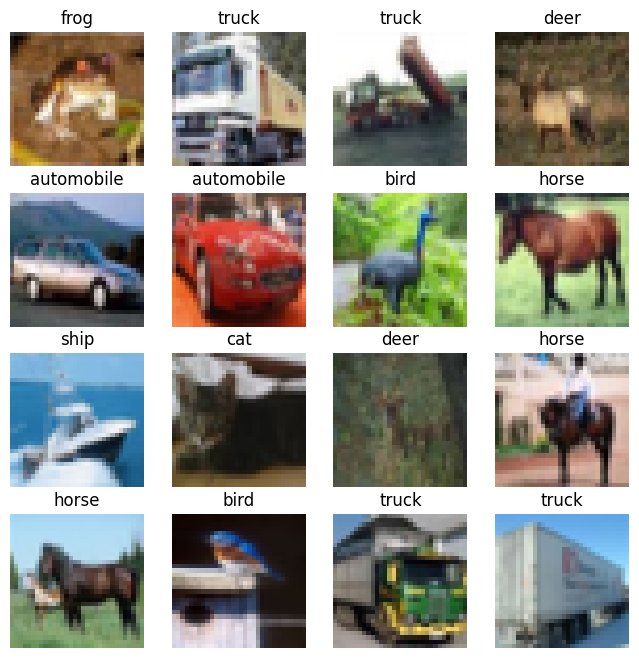

In [9]:
cols = 4 # Number of columns
rows = 4 # Number of rows

# grab the samples from the training set
samples = training_data.data[:cols*rows]
labels = training_data.targets[:cols*rows]

fig = plt.figure(figsize=(2 * cols, 2 * rows))

i = 0

# Add subplot for each image
for col in range(cols):
    for row in range(rows):

        ax = fig.add_subplot(rows, cols, col * rows + row + 1) # Add a sub-plot at (row, col)
        ax.axis("off") # Get rid of the axis
        ax.imshow(samples[i, :]) # Show random image
        ax.set_title(CIFAR10_CLASSES[labels[i]]) # Set title of the sub-plot

        i = i + 1
plt.show()

### Creating Functions to Train and Test the Data

In [14]:
# Single Epoch Training Function
def train_for_epoch():

    # put model in train mode
    model.train()

    # keep track of the training losses during the epoch
    train_losses = []

    # Reconstruction
    for batch, targets in tqdm(training_loader):

        # Move the training data to the GPU
        batch = batch.to(device)
        targets = targets.to(device)

        # clear previous gradient computation
        optimizer.zero_grad()

        # forward propagation
        predictions = model(batch)

        # calculate the loss
        loss = criterion(predictions, targets) # calculating loss

        # backpropagate to compute gradients
        loss.backward() # calculating the gradient

        # update model weights
        optimizer.step() # W_new = W_old - A*gradient

        # update running loss value
        train_losses.append(loss.item())

    train_loss = np.mean(train_losses)

    return train_loss

In [15]:
# Test Function
def test():

    # put model in evaluation mode
    model.eval()

    # keep track of losses and predictions
    test_losses = []
    test_predictions = []

    # We don't need gradients for validation, so wrap in
    # no_grad to save memory

    with torch.no_grad():

        for batch, targets in tqdm(testing_loader):

            # Move the testing data to the GPU
            batch = batch.to(device)
            targets = targets.to(device)

            # forward propagation
            predictions = model(batch)

            # calculate the loss
            loss = criterion(predictions, targets)

            # update running loss value
            test_losses.append(loss.item())

            # save predictions
            test_predictions.extend(predictions.argmax(dim=1).cpu().numpy())

    # compute the average TEST loss
    test_loss = np.mean(test_losses)

    # Collect predictions into y_pred and ground truth into y_true
    y_pred = np.array(test_predictions, dtype=np.float32)
    y_true = np.array(testing_data.targets, dtype=np.float32)

    # Calculate accuracy as the average number of times y_true == y_pred
    accuracy = np.mean([y_pred[i] == y_true[i] for i in range(len(y_true))])

    return test_loss, accuracy

In [16]:
# Final Train Function
def train(first_epoch, num_epochs):

    train_losses = []
    test_losses = []
    epoch_num = []

    for epoch in range(first_epoch, first_epoch + num_epochs):

        # track the epoch number
        epoch_num.append(epoch)

        # training phase
        train_loss = train_for_epoch()
        train_losses.append(train_loss)

        # test phase
        test_loss, test_accuracy = test()

        print(f'[{epoch:03d}] train loss: {train_loss:04f}',
                f'test loss: {test_loss:04f}',
                f'test accuracy: {test_accuracy:04f}')

        test_losses.append(test_loss)

        # Save a checkpoint
        checkpoint_filename = f'checkpoints/cifar10-mlp-{epoch:03d}.pkl'

        print('')

    return epoch_num, train_losses, test_losses

### Building the Model

In [21]:
# Use the pre-trained VGG-16 architecture

# Define the model

model = torchvision.models.vgg16(pretrained = True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [22]:
# Replace the last layer with our own fully conncected layer

# Find the in-features of VGG's last layer which will be replaced
in_features = model.classifier[-1].in_features

# Output features will be the number of classes in our dataset, i.e. 10
out_features = 10

# Replace the last layer with a fully-connected linear layer
model.classifier[-1] = nn.Linear(in_features, out_features)

# Bring on the GPU
model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

### Training

In [23]:
# Create the optimizer and the loss functions

# Loss
criterion = torch.nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [24]:
# Train for 5 epochs
epochs, train_losses, test_losses = train(1, 5)

100%|██████████| 79/79 [00:55<00:00,  1.43it/s]


[001] train loss: 1.025013 test loss: 0.379350 test accuracy: 0.869300



100%|██████████| 79/79 [00:55<00:00,  1.43it/s]


[002] train loss: 0.764452 test loss: 0.327901 test accuracy: 0.886700



100%|██████████| 79/79 [00:55<00:00,  1.42it/s]


[003] train loss: 0.697097 test loss: 0.323389 test accuracy: 0.891100



100%|██████████| 79/79 [00:55<00:00,  1.43it/s]


[004] train loss: 0.655439 test loss: 0.278482 test accuracy: 0.900800



100%|██████████| 79/79 [00:55<00:00,  1.43it/s]

[005] train loss: 0.633081 test loss: 0.262132 test accuracy: 0.907900



### Learning Curves


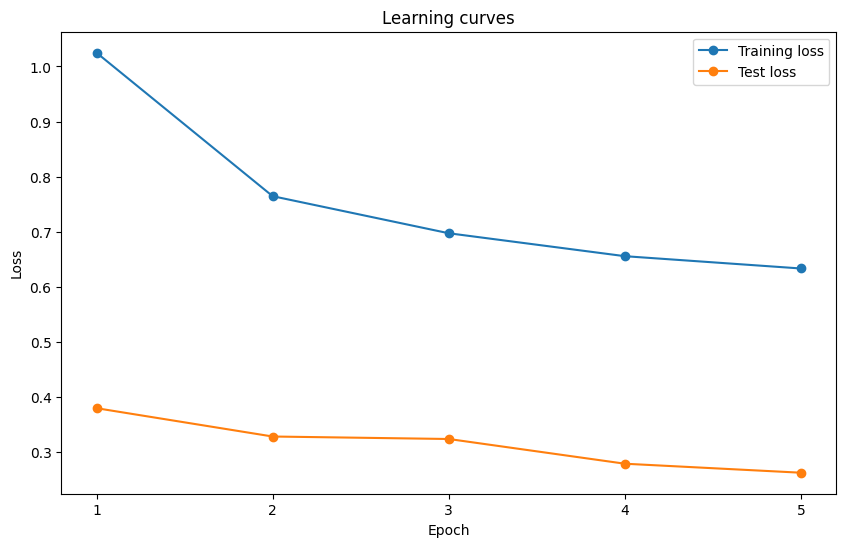

In [25]:
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(10,6))
plt.plot(epochs, train_losses, '-o', label='Training loss')
plt.plot(epochs, test_losses, '-o', label='Test loss')
plt.legend()
plt.title('Learning curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(epochs)
plt.show()